## Brandon Ritchie Yang
### Financial Sentiment Analysis

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nlpaug.augmenter.word as naw

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [ ]:
df = pd.read_csv('sentiment_analysis_data.csv')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


The unique values of 'negative' and 'positive' sentiment have the same number of the count value, while the unique value of 'neutral' is not the same with the count value, meaning there might be duplicated data (the frequency of the text is also 2)

In [ ]:
df.groupby('Sentiment').describe()

Sentence                                                            \
             count unique                                                top   
Sentiment                                                                      
negative       860    860  $ESI on lows, down $1.50 to $2.50 BK a real po...   
neutral       3130   3124  SSH Communications Security Corporation is hea...   
positive      1852   1852  The GeoSolutions technology will leverage Bene...   

                
          freq  
Sentiment       
negative     1  
neutral      2  
positive     1

After checking for duplicates, there are 6 duplicated data which are correct in the 'neutral' data since 3130 minus 3124 is 6

In [ ]:
df.duplicated().sum()

6

In [ ]:
df.isnull().sum()

,0
Sentence,0
Sentiment,0


Since there are duplicated data, the dupliated data will be drop so it will not affect the quality of the data

In [ ]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [ ]:
df['Sentiment'].value_counts()

,count
Sentiment,
neutral,3124
positive,1852
negative,860


The distribution of the label is not balance where there are so many neutral and the negative sentiment is so little. it is around 1:2:3 ratio

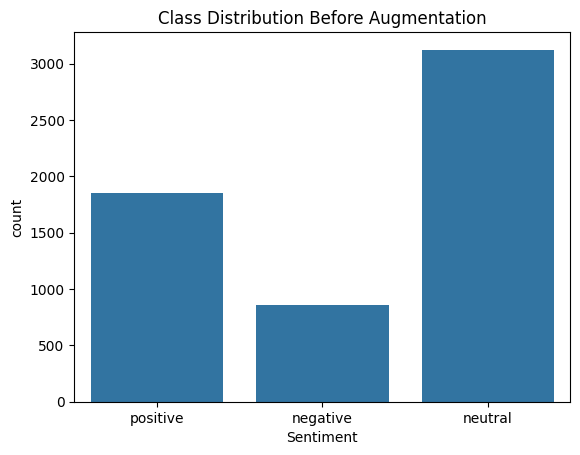

In [ ]:
sns.countplot(x='Sentiment', data=df)
plt.title('Class Distribution Before Augmentation')
plt.show()

To balance the data, data augmentation is perform to the less class and increase the amount of data to the most class. The augmentation is perform by changing 10% of the word from the sentence with the synonym of the word

In [ ]:
aug = naw.SynonymAug(aug_p=0.1)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
def augment_data(df, target_class, augmenter, num_augmented):
  df_target = df[df['Sentiment'] == target_class]
  augmented_reviews = []
  for _ in range(num_augmented):
    review = df_target.sample(n=1).iloc[0]['Sentence']
    augmented_review = augmenter.augment(review)
    augmented_reviews.append({'Sentence': augmented_review, 'Sentiment': target_class})
  augmented_df = pd.DataFrame(augmented_reviews)
  return augmented_df

In [ ]:
most_label = df['Sentiment'].value_counts().max()

augmentation_needed = {}
for i, count in df['Sentiment'].value_counts().items():
    if count < most_label:
        augmentation_needed[i] = most_label - count

print("Augmentation needed:")
print(augmentation_needed)

Augmentation needed:
{'positive': 1272, 'negative': 2264}


In [ ]:
augmented_dfs = []
for i, num in augmentation_needed.items():
    augmented_df = augment_data(df, i, aug, num)
    augmented_dfs.append(augmented_df)

df_augmented = pd.concat(augmented_dfs, ignore_index=True)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
df_augmented.head(20)

,Sentence,Sentiment
0,"[Svyturys - Utenos Alus, which is ensure by th...",positive
1,[The fair value of investment properties tot E...,positive
2,[$ GOOGL gets an upgrade price target $ 970],positive
3,[$ TROW Ascending triangle gives a bullish bia...,positive
4,[This be the first time Finnair has be awarded...,positive
5,"[According to PKC, the acquisition would bring...",positive
6,[FTSE butt up as investors cheer Kingfisher re...,positive
7,[Wartsila won the contract in October 2007 and...,positive
8,[Insistency release nina from carolina October...,positive
9,[Citrix Systems Inc $ CTXS Lieu Increased by M...,positive


The class is now balanced

In [ ]:
df_balance = pd.concat([df, df_augmented], ignore_index=True)
df_balance['Sentiment'].value_counts()

,count
Sentiment,
positive,3124
negative,3124
neutral,3124


In [ ]:
df_balance.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


Encode the label to numerical values

In [ ]:
encode = {"Sentiment": {"negative": 0, "neutral": 1, "positive": 2}}
df_balance = df_balance.replace(encode)
df_balance.head()

<ipython-input-19-7e94b207e4cc>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_balance = df_balance.replace(encode)


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,2
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0
2,"For the last quarter of 2010 , Componenta 's n...",2
3,According to the Finnish-Russian Chamber of Co...,1
4,The Swedish buyout firm has sold its remaining...,1


Pre process the text data by removing non alphanumeric characters like symbols, the lowercase the text so it all have the same format, tokenize the data, remove the stop words and perform stemming. Stop word is remove because stop word is a word that is widely use and have very little useful information, stemming is perform to simplify and standardize the word.

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Lowercase
    text = text.lower()
    # Tokenize
    tokens = text.split()
    # Remove stop words and stem
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    # Join back to string
    return ' '.join(tokens)

df_balance['Sentence'] = df_balance['Sentence'].astype(str).apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


split data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_balance['Sentence'], df_balance['Sentiment'],test_size=0.2, stratify=df_balance['Sentiment'])

In [ ]:
X_train.head()

,Sentence
4509,fiscal year end septemb 30 2009 revenu custom ...
9310,omx helsinki index 0 34 pct 8 256 02 turnov 81...
7950,oper loss amount eur 0 9 minnesota initi one h...
8933,pretax loss total eur 1 two mn profit eur deuc...
2195,2006 452 million tonn co2 eua eu allow emiss c...


Perform TFIDF vectorizer to vectorize the text and give the weight to the text that have important information, this is use to give the word representation of how important the word is

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
tfidf_matrix_train = vectorizer.fit_transform(X_train)
tfidf_matrix_test = vectorizer.transform(X_test)
tfidf_df_train = pd.DataFrame(tfidf_matrix_train.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df_test = pd.DataFrame(tfidf_matrix_test.toarray(), columns=vectorizer.get_feature_names_out())

The word cloud visualize the most common or the most frequent word appear in the data, the bigger the size of the word means the more frequent  it is, the word like 'eur', 'profit', 'sale', 'net' have more frequent occurance, while word like 'system', 'deal' and other small size word have less frequent occurance.

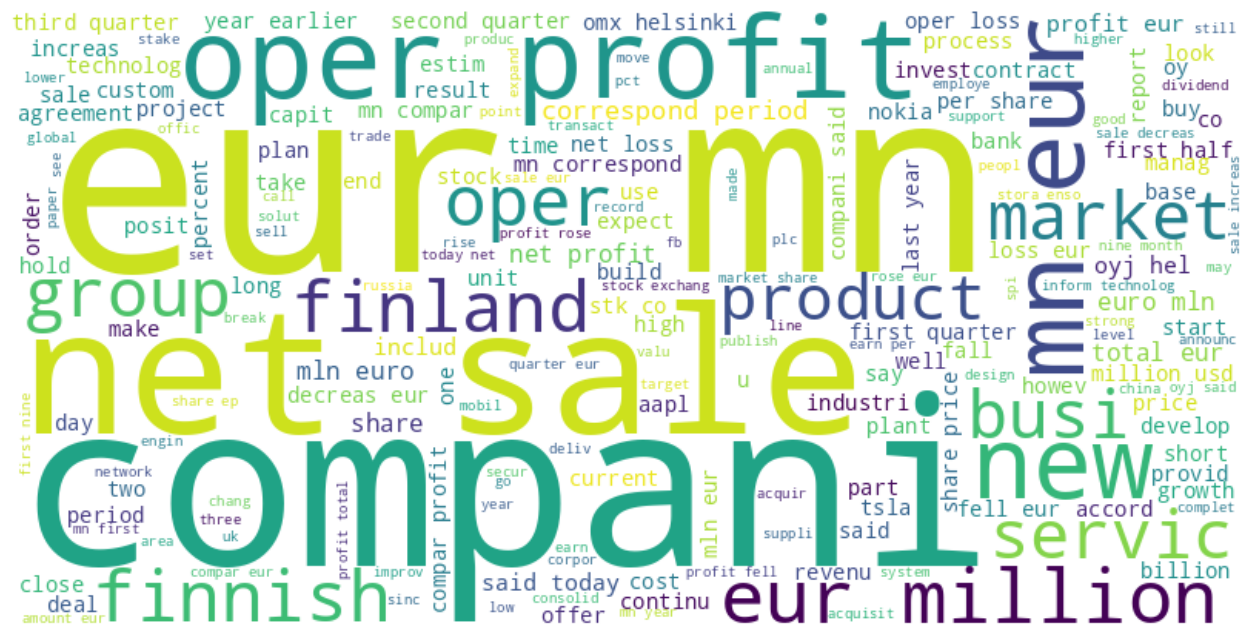

In [ ]:
all_reviews = ' '.join(X_train.astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The model use for classifications are LogisticRegression, Support Vector Classifier, and mulitnomial naive bayes.

In [ ]:
classifier = LogisticRegression()
classifier.fit(tfidf_df_train, y_train)
y_pred = classifier.predict(tfidf_df_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.83      0.80       625
           1       0.73      0.72      0.72       625
           2       0.82      0.77      0.80       625

    accuracy                           0.77      1875
   macro avg       0.77      0.77      0.77      1875
weighted avg       0.77      0.77      0.77      1875



In [ ]:
SVM_class = make_pipeline(SVC())
SVM_class.fit(tfidf_df_train, y_train)
y_predict_svm = SVM_class.predict(tfidf_df_test)

In [ ]:
print(classification_report(y_test, y_predict_svm))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       625
           1       0.76      0.78      0.77       625
           2       0.91      0.83      0.87       625

    accuracy                           0.83      1875
   macro avg       0.83      0.83      0.83      1875
weighted avg       0.83      0.83      0.83      1875



In [ ]:
NB_class = MultinomialNB()
NB_class.fit(tfidf_df_train, y_train)
y_predict_NB = NB_class.predict(tfidf_df_test)

In [ ]:
print(classification_report(y_test, y_predict_NB))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75       625
           1       0.69      0.76      0.72       625
           2       0.79      0.71      0.75       625

    accuracy                           0.74      1875
   macro avg       0.74      0.74      0.74      1875
weighted avg       0.74      0.74      0.74      1875



The Support Vector Classifier has the highest accuracy of 83% while the recall range from 78% - 87%. The logistic regression model is the second best model with the 77% accuracy and the recal range from 72% - 83%. And the last model is nauve bayes with 74% accuracy with recall range from 71% - 76%.